In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
import matplotlib.pyplot as plt
import random

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
## Access to the google drive
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [5]:
##loading the data
class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            #convert the RGBA into RGB
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            mask = get_mask(mask_folder, 128, 128 ).astype('float32')
            boxes = get_bounding_box(mask_folder, 128, 128 )

            # convert everything into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)

            #augmentation
            augmented = self.transforms(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']
            
            #target structure
            final_target = []
            final_image = []
            num_objs = len(boxes)
            target = {}
            target["boxes"] = boxes 

            #there is only one class 
            target["labels"] =  torch.ones((num_objs,), dtype=torch.int64)   # there is only one class
            target["masks"] = mask
            final_target.append(target)
            final_image.append(img)
            return (final_image,final_target) 

In [11]:
#loading the data
data_dir = '/content/MyDrive/MyDrive/stage1_train/'
data = Nuclie_data(data_dir)

In [12]:
#data size
print(data.__len__())

670


In [ ]:
img, target = data.__getitem__(25)

In [211]:
img

[tensor([[[-0.8871, -0.8877, -0.8943,  ..., -0.0647,  0.0155, -0.4878],
          [-0.8950, -0.8971, -0.8966,  ..., -0.6229, -0.6271, -0.7140],
          [-0.8869, -0.8917, -0.8924,  ..., -0.7910, -0.8070, -0.8207],
          ...,
          [-0.8888, -0.8936, -0.8939,  ..., -0.9028, -0.9025, -0.9037],
          [-0.8902, -0.8941, -0.8943,  ..., -0.9036, -0.9005, -0.9069],
          [-0.8976, -0.8961, -0.8924,  ..., -0.9005, -0.9015, -0.9025]],
 
         [[-0.8871, -0.8877, -0.8943,  ..., -0.0647,  0.0155, -0.4878],
          [-0.8950, -0.8971, -0.8966,  ..., -0.6229, -0.6271, -0.7140],
          [-0.8869, -0.8917, -0.8924,  ..., -0.7910, -0.8070, -0.8207],
          ...,
          [-0.8888, -0.8936, -0.8939,  ..., -0.9028, -0.9025, -0.9037],
          [-0.8902, -0.8941, -0.8943,  ..., -0.9036, -0.9005, -0.9069],
          [-0.8976, -0.8961, -0.8924,  ..., -0.9005, -0.9015, -0.9025]],
 
         [[-0.8871, -0.8877, -0.8943,  ..., -0.0647,  0.0155, -0.4878],
          [-0.8950, -0.8971,

In [212]:
target

[{'boxes': tensor([[ 56.,  44.,  62.,  50.],
          [ 48.,  63.,  55.,  70.],
          [  3.,  29.,   8.,  34.],
          [  0.,  32.,   6.,  42.],
          [ 42.,  86.,  50.,  93.],
          [113.,  35., 120.,  40.],
          [ 53.,  49.,  58.,  55.],
          [  4.,  31.,  10.,  37.],
          [ 56.,  55.,  63.,  62.],
          [  8.,  21.,  17.,  30.],
          [ 84.,  51.,  93.,  60.],
          [102.,   1., 108.,   7.],
          [ 30.,  58.,  36.,  66.],
          [ 45.,  52.,  50.,  59.],
          [ 97.,   4., 104.,  11.],
          [ 29.,  38.,  35.,  43.],
          [  9.,  12.,  15.,  18.],
          [115.,  42., 121.,  47.],
          [ 34.,  36.,  40.,  41.],
          [ 61.,  53.,  69.,  59.],
          [ 33.,  76.,  43.,  84.],
          [ 30.,   3.,  36.,   9.],
          [ 34.,  28.,  43.,  36.],
          [ 22.,  24.,  29.,  32.],
          [ 32.,  62.,  40.,  70.],
          [ 48.,  77.,  56.,  86.],
          [ 51.,  41.,  59.,  50.]]),
  'labels': tenso

In [7]:
##integrate the multiple masks into one mask
def get_mask(mask_folder,IMG_HEIGHT, IMG_WIDTH):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
              
    return mask

In [6]:
##convert the image into tensors
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0.5), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms


In [9]:
#randomly view the images and combined masks
def plot_img(no_, data, device):
    data_size = data.__len__()
    images = []
    masks =[]
    plt.figure(figsize=(10,6))
    for i in range(0,no_):
        idx=random.randint(0,data_size-1)
        ig, ms = data.__getitem__(idx)
        image = ig[0].to(device)
        image = image_convert(image)
        plt.subplot(2,no_,i+1)
        plt.title('image')
        plt.imshow(image)
        
        mask = ms[0]
        mask = mask['masks']
        mask = mask.to(device)
        mask = mask_convert(mask)
        plt.subplot(2,no_,i+no_+1)
        plt.title('mask')
        plt.imshow(mask,cmap='gray')
    plt.show()

In [8]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    #mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


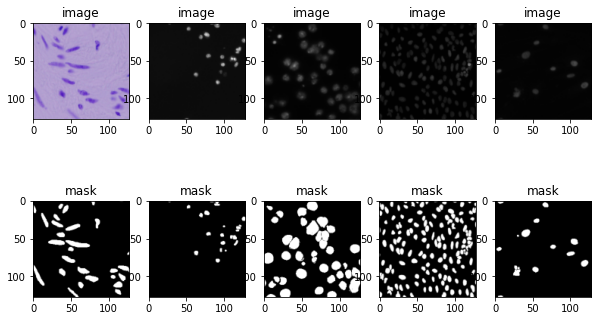

In [14]:
plot_img(5, data, device)

In [4]:
##get the bounding box for each individual mask 
def get_bounding_box(mask_folder,IMG_HEIGHT, IMG_WIDTH):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    boxes = []
    for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            ###get the bounding box
            pos = np.where(mask_)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
              
    return boxes

In [241]:
def plot_box(data, num, box = None):
    img, mak = data.__getitem__(num)

    if box is None:
       box = mak[0]
       box = box['boxes']
       box = box.clone().cpu().detach().numpy()

    for idx in range(len(box)):
        tmp_box = box[idx]
        x_min = tmp_box[0]
        y_min = tmp_box[1]
        x_max = tmp_box[2]
        y_max = tmp_box[3]
        start_point = (int(x_min), int(y_min))
        end_point = (int(x_max), int(y_max))
        if idx == 0:
           plt_box = cv2.rectangle(image_convert(img[0]), start_point, end_point, colors, thickness)
        else:
           plt_box = cv2.rectangle(plt_box, start_point, end_point, colors, thickness)

    return plt_box


<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


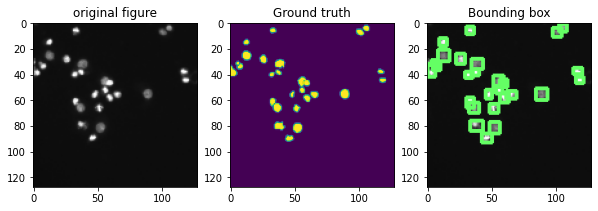

In [203]:
## showing the bounding box
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
img, mak = data.__getitem__(25)
plt.imshow(image_convert(img[0]))

plt.subplot(1,3,3)
plt.title('Bounding box')
plt.imshow(plot_box(data, 25))

plt.subplot(1,3,2)
mak = mak[0]
plt.title('Ground truth')
plt.imshow(mask_convert(mak['masks']))

# Loading the pre-trained model 

In [15]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [16]:
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

In [18]:
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nuclei) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
model.to(device)# move model to the right device

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-5)
model.train()

# Training Model 

In [21]:
train_set = 580
loss_epoch = []
for i in range(501):       
    #images, targets = get_target()
    idx=random.randint(0,train_set-1)
    images, targets = data.__getitem__(idx)
    #iter_ = iter(train_loader)
    #images,masks = next(iter_)
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
    print(f"start iteration {i}")
    optimizer.zero_grad()
    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses.backward()
    optimizer.step()
    print(i,'loss:', losses.item())
    loss_epoch.append(losses.item())
    #save model for every 100 iteration 
    if i%100==0:
       torch.save(model.state_dict(), str(i)+".torch")

<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


start iteration 0
0 loss: 5.2602691650390625
start iteration 1
1 loss: 3.1751952171325684
start iteration 2
2 loss: 2.216616630554199
start iteration 3
3 loss: 2.5982611179351807
start iteration 4
4 loss: 1.2224810123443604
start iteration 5
5 loss: 2.348140001296997
start iteration 6
6 loss: 2.495448112487793
start iteration 7
7 loss: 6.126527786254883
start iteration 8
8 loss: 1.9890555143356323
start iteration 9
9 loss: 3.498093366622925
start iteration 10
10 loss: 2.0518486499786377
start iteration 11
11 loss: 1.5874245166778564
start iteration 12
12 loss: 1.1160016059875488
start iteration 13
13 loss: 2.1001524925231934
start iteration 14
14 loss: 1.9671192169189453
start iteration 15
15 loss: 1.277328372001648
start iteration 16
16 loss: 1.188610553741455
start iteration 17
17 loss: 0.8837276697158813
start iteration 18
18 loss: 2.963620662689209
start iteration 19
19 loss: 0.8064109086990356
start iteration 20
20 loss: 0.6985907554626465
start iteration 21
21 loss: 1.49805080890

# Model Evaluation


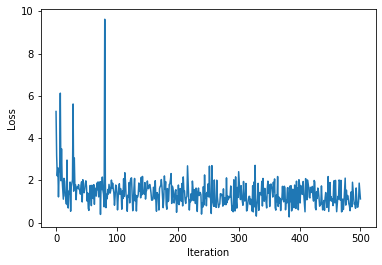

In [204]:
# Plot loss
plt.plot(list(range(501)), loss_epoch)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [205]:
#load the pre-trained model 
model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
in_features = model.roi_heads.box_predictor.cls_score.in_features 
model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes=2)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#load your model and set the model to evaluation state
model.load_state_dict(torch.load("500.torch"))
model.eval()

In [213]:
### get one testing image 
imag, mak = data.__getitem__(640)
img = list(image.to(device) for image in imag)

<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [217]:
# testing the model 
with torch.no_grad():
    pred = model(img)

In [218]:
pred

[{'boxes': tensor([[5.7217e+01, 3.5610e+01, 6.6693e+01, 4.2450e+01],
          [8.0100e+01, 5.1637e+01, 8.9665e+01, 6.0459e+01],
          [6.4753e+01, 5.7284e+01, 7.4138e+01, 6.7974e+01],
          [9.2337e+01, 6.6075e+01, 1.0186e+02, 7.5256e+01],
          [1.0739e+02, 8.1472e+01, 1.1641e+02, 9.2068e+01],
          [7.9347e+01, 7.3980e+01, 8.7940e+01, 8.3941e+01],
          [8.5749e+01, 1.0887e+01, 9.3428e+01, 2.1562e+01],
          [5.3988e+01, 6.0535e+01, 6.2656e+01, 6.8745e+01],
          [8.7236e+01, 7.5446e+01, 9.7377e+01, 8.4474e+01],
          [8.8594e-01, 1.1265e+02, 1.1121e+01, 1.2174e+02],
          [3.1992e+01, 1.1992e+02, 4.0104e+01, 1.2716e+02],
          [3.5903e+01, 7.4920e+01, 4.4005e+01, 8.4577e+01],
          [7.3804e+01, 4.5475e+01, 8.2822e+01, 5.3995e+01],
          [1.1867e+02, 7.1178e+01, 1.2699e+02, 8.0813e+01],
          [6.9367e+01, 1.9779e+00, 7.9785e+01, 1.0962e+01],
          [1.0533e+02, 1.1725e+02, 1.1202e+02, 1.2603e+02],
          [2.4337e+01, 8.6947e+

In [224]:
## get and combined predicted mask with confident score > 0.8
mask = np.zeros((128, 128, 1), dtype=np.bool)
for i in range(len(pred[0]['masks'])):
    msk=pred[0]['masks'][i,0].detach().cpu().numpy()
    scr=pred[0]['scores'][i].detach().cpu().numpy()
    if scr > 0.7 :
       msk = transform.resize(msk, (128, 128))
       msk = np.expand_dims(msk,axis=-1)
       mask = np.maximum(mask, msk)
        

<ipython-input-224-c98b83e2ce96>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((128, 128, 1), dtype=np.bool)


In [229]:
scr=pred[0]['scores'].detach().cpu().numpy()

In [238]:
def get_predicted_box(data, num, model, cutoff = 0.7):
    
    filtered_box = []
    ### get one testing image 
    imag, mak = data.__getitem__(num)
    img = list(image.to(device) for image in imag)

    # testing the model 
    with torch.no_grad():
         pred = model(img)

    for i in range(len(pred[0]['boxes'])):
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > cutoff :
           filtered_box.append(box)
    return filtered_box

In [248]:
#Get the predicted boxes in #630 image when confident score > 0.7
pred_box = get_predicted_box(data, 630, model)
p_07 = plot_box(data, num = 630, box = pred_box)

<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


In [249]:
## get all of predicted boxes 
pred_box = get_predicted_box(data, 630, model, cutoff = 0)
p_0 = plot_box(data, num = 630, box = pred_box)

<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


<ipython-input-7-266426c978ca>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


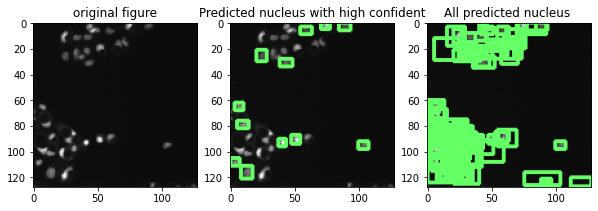

In [250]:
## show the predicted results 
plt.figure(figsize=(10,6))
plt.subplot(1,3,1)
plt.title('original figure')
img, mak = data.__getitem__(630)
plt.imshow(image_convert(img[0]))

plt.subplot(1,3,2)
plt.title('Predicted nucleus with high confident')
plt.imshow(p_07)

plt.subplot(1,3,3)
plt.title('All predicted nucleus ')
plt.imshow(p_0)